In [486]:
# !pip install -U scikit-learn

In [487]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datos_2c2020_tp2.log.Logger as logger


# TP2 - XGBoost example

El objetivo es crear un primer modelo básico de XGBoost, sin feature engineering ni hyperparameters tunning, para poder tener un primer resultado local. Luego, realizar un primer submit en kaggle y en base a eso ir mejorando el modelo

In [488]:
train = pd.read_csv("../datasets/first-rf-model-train.csv")
test = pd.read_csv("../datasets/first-rf-model-test.csv")

train['Month'] = pd.to_datetime(train['Month']).dt.month
test['Month'] = pd.to_datetime(test['Month']).dt.month

In [489]:
test.head(2)

,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Opportunity_ID,Sales_Contract_No,ASP,ASP_(converted),Month,Delivery_Year,...,Last_Modified_By_2,Last_Modified_By_3,Last_Modified_By_4,Last_Modified_By_5,Total_Taxable_Amount_Currency_0,Total_Taxable_Amount_Currency_1,Total_Taxable_Amount_Currency_2,Total_Amount_Currency_0,Total_Amount_Currency_1,Total_Amount_Currency_2
0,1,1,1,1,10689,6436,0.325,0.36761,5,2019,...,0,1,0,0,0,0,1,0,0,1
1,1,1,1,1,10689,6436,0.320,0.36195,5,2019,...,0,1,0,0,0,0,1,0,0,1


In [490]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
              colsample_bytree = 0.3, learning_rate = 0.1,
              max_depth = 9, alpha = 20, n_estimators = 200)

In [491]:
target = "target"
features = list(train.columns)
features.remove(target)
features.remove("Opportunity_ID")
len(features)


109

In [492]:
X_train, y_train = train.loc[:,features],train.loc[:,target]
X_test_Opp = test.loc[:,"Opportunity_ID"]
X_test = test.loc[:,features]



In [493]:
print(X_train.shape)
print(X_test.shape)

(16947, 109)
(2551, 109)


In [494]:


xg_reg.fit(X_train,y_train)


XGBRegressor(alpha=20, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=20, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [495]:
preds = xg_reg.predict(X_test)


In [496]:
pred_df = pd.DataFrame(X_test_Opp)
pred_df["Target"] = preds
pred_df = pred_df.drop_duplicates("Opportunity_ID")
pred_df
pred_df.to_csv("../submits/xgb_model1.csv",index=False)

#

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

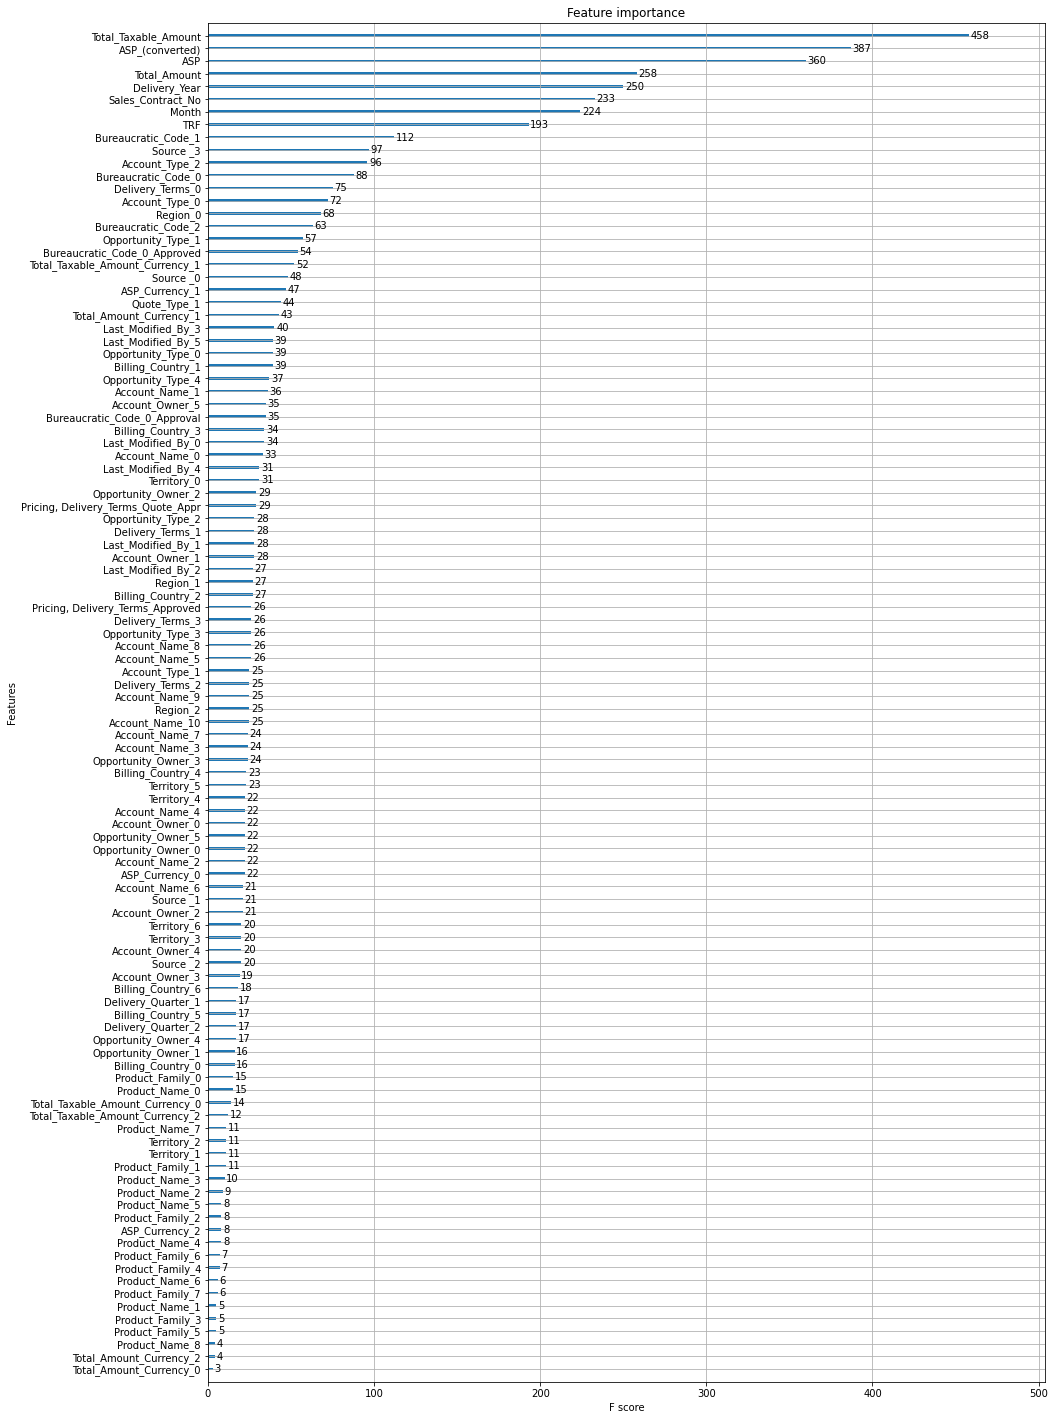

In [497]:
plt.rcParams['figure.figsize'] = [15, 25]
xgb.plot_importance(xg_reg)



In [498]:

data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,
          'learning_rate': 0.1, 'max_depth': 20, 'alpha': 10}



cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=23939)
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.484600,0.000332,0.485831,0.000083
1,0.458711,0.009824,0.460580,0.010485
2,0.420893,0.008914,0.422878,0.009532
3,0.402061,0.011734,0.404437,0.011829
4,0.384577,0.016846,0.387402,0.017605


In [499]:
cv_score = (cv_results["test-rmse-mean"]).tail(1)

print(cv_score)


49    0.196241
Name: test-rmse-mean, dtype: float64


In [500]:
logger.Logger.log_model("xgb", params, features, cv_score, notes="Primer submit de kaggle 0.20511")

Writing..
Model => xgb
Hyperparameters => 5
	objective: reg:squarederror
	colsample_bytree: 0.3
	learning_rate: 0.1
	max_depth: 20
	alpha: 10
Features =>  109
	Pricing, Delivery_Terms_Quote_Appr
	Pricing, Delivery_Terms_Approved
	Bureaucratic_Code_0_Approval
	Bureaucratic_Code_0_Approved
	Sales_Contract_No
	ASP
	ASP_(converted)
	Month
	Delivery_Year
	TRF
	Total_Amount
	Total_Taxable_Amount
	Delivery_Quarter_0
	Delivery_Quarter_1
	Delivery_Quarter_2
	ASP_Currency_0
	ASP_Currency_1
	ASP_Currency_2
	Account_Owner_0
	Account_Owner_1
	Account_Owner_2
	Account_Owner_3
	Account_Owner_4
	Account_Owner_5
	Region_0
	Region_1
	Region_2
	Billing_Country_0
	Billing_Country_1
	Billing_Country_2
	Billing_Country_3
	Billing_Country_4
	Billing_Country_5
	Billing_Country_6
	Opportunity_Owner_0
	Opportunity_Owner_1
	Opportunity_Owner_2
	Opportunity_Owner_3
	Opportunity_Owner_4
	Opportunity_Owner_5
	Product_Name_0
	Product_Name_1
	Product_Name_2
	Product_Name_3
	Product_Name_4
	Product_Name_5
	Product_Nam